<H1 style="text-align: center">ECMM422 - Machine Learning</H1>
<H2 style="text-align: center">Assignment 1: Classifiers</H2>



| <font style="font-size:larger;">Date set     | <font style="font-size:larger;">Hand-in date |
|:------------------|:-----------------------------------|
|<font style="font-size:larger;"> 24th January 2019 |<font style="font-size:larger;">**  12 noon, Wednesday 5th February 2020** |

</font>

Candidate number:  <font color="red">*660031764*</font>

Marking is anonymous, so please don't write your name or reveal your identity!


The module assessment is comprised of your IPython notebooks. There will be four marked assignments, of which this is the first. All assignments will be equally weighted and therefore worth 25% of your module mark. 


Your IPython notebook should show what you did, what was the
result, and what you can conclude from the exercise. For some reports you will need to comment on a paper you have read.   Each report will be
assessed on the following criteria:

* Does it record what was done in the exercise?
* Does it permit the results to be reproduced?
* How does the work relate to the theoretical foundations discussed in lectures?
* Is it well presented?

### Submitting the notebooks

Note that an electronic submission is required.  You should also submit the notebook electronically at [electronic hand-in system]( http://empslocal.ex.ac.uk/submit/).  You just need to submit the single .ipynb file that is the notebook, so you should be able to upload it directly from the directory where you have saved it on a University machine or your laptop.  If you're not sure where in your homespace it is, type <code>pwd</code> (print working directory) in a cell to find out where the notebooks are.

<b>Note: you must also submit your cover sheet and E-Submit receipt via BART to complete the submission.</b>



<div class="alert alert-info">
 Although you will undoubtedly work collaboratively in the workshops themselves, these are *individual* exercises.  The reports you write should be about the results *you* obtained, and your attention is drawn to the College and University guidelines on collaboration and plagiarism. 
 </div>

We import all of the modules we require for the notebook (to make it easier to run specific cells without the need to run all previous cells):

In [160]:
#We import all modules we require
import numpy as np
import matplotlib.pyplot as plt 
from random import randint
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import Normalize
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn import neighbors
from sklearn.model_selection import KFold
from sklearn import metrics
from tqdm import tqdm_notebook as tqdm


## 1. Classification

In the first part of this workshop, we will work on a simple classification problem with synthetic data. The dataset has one binary target $t\in \{0,1\}$ and two features $\mathbf{x} = [x_1,x_2]$. This will allow to visualise the data and model decision boundary on 2D plots.

First, you should download and load the data in from two files on the VLE, the files should be placed in the same folder as the jupyter notebook. The files contain the $\mathbf{x}$ and $t$ values for 500 samples.

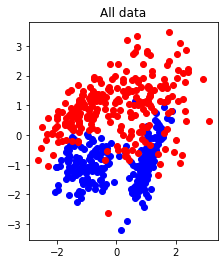

In [161]:
# we first load each file in a separate array
Xall = np.load('ecmm422_ca1_part1_X.npy')
tall = np.load('ecmm422_ca1_part1_t.npy')

# then we plot all data using matplotlib - note the indexing to select only samples from one class or the other
plt.plot(Xall[tall==0, 0], Xall[tall==0, 1], 'bo')
plt.plot(Xall[tall==1, 0], Xall[tall==1, 1], 'ro')
plt.axis('scaled')
plt.title('All data')
plt.show()

It is clear that it cannot be completely separated by a straight line, so these data are said not to be "linearly separable".

The first step in any machine learning work will be to separate and put aside a test set for final evaluation. Often this set will be sampled randomly from the available data, but for this workshop we will use a specific subset of half the data so that performance is comparable. 

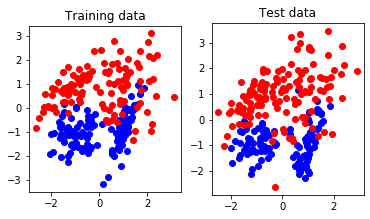

In [162]:
I = range(len(tall))    # you could change this for np.random.permutation(len(tall)) to get a random selection
                        # do not do this for this workshop as I want to be able to compare final performance. 

Itrain = I[:len(tall)//2]   # First half of indices for training
Itest = I[len(tall)//2:]    # Second half for test

Xtr = Xall[Itrain,:] # we define variables for the training set...
ttr = tall[Itrain]   

Xte = Xall[Itest,:]  # ... and for the test set
tte = tall[Itest]   

# then we plot both sets
plt.subplot(121)
plt.plot(Xtr[ttr==0, 0], Xtr[ttr==0, 1], 'bo')
plt.plot(Xtr[ttr==1, 0], Xtr[ttr==1, 1], 'ro')
plt.axis('scaled')
plt.title('Training data')

plt.subplot(122)
plt.plot(Xte[tte==0, 0], Xte[tte==0, 1], 'bo')
plt.plot(Xte[tte==1, 0], Xte[tte==1, 1], 'ro')
plt.axis('scaled')
plt.title('Test data')

# note that we would usually also label axes, but in this case the features 
# are unnamed so this would not add much information. 

plt.show()


Good. We can see in those plots that the two distributions are comparable, so we did not create a pathological split (eg, one that would contain only one class!) by accident. 

<b>NB:</b> We must <b>not</b> use the test data as part of the training process.

We will use three different algorithms in this workshop: k-NN, Neural Networks and decision trees. 

### 1.1 Classification with k-nearest neighbours
As a first step, we will try to model the dataset distribution using k-Nearest Neighbours. 
We will use the k-nearest neighbour classifier from scikit learn, which is  quite an extensive implementation of various machine learning algorithms.

To start off, we use **all** the training data. We choose k=5 as the number of nearest neighbours to begin:

In [163]:
k = 5   # Choose the number of nearest neighbours

knn = neighbors.KNeighborsClassifier(n_neighbors=k)
knn.fit(Xtr, ttr)

# we can get the performance on the training set
Str = knn.score(Xtr, ttr)

# we can also calculate the performance on the test set: 
Ste = knn.score(Xte, tte)

print('Performance with k=%i,\n\t- on training set %f \n\t- on test set %f' % (k, Str, Ste))


Performance with k=5,
	- on training set 0.952000 
	- on test set 0.916000


In the following cell, we will set up a grid of points to be classified over the whole domain and then classify them with the k-nn classifier, plotting the result in the corresponding place on the grid.  This gives a nice visualisation of the classfier's performance.


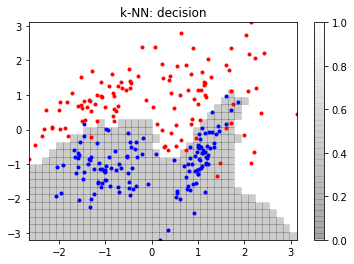

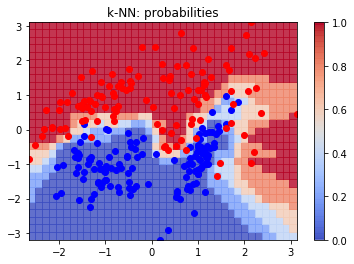

In [164]:
# we use this to calculate classification accuracy, you can as easily calculate it by hand though. 

def plot_decision_regions(X, t, model, label='model', show_decision=True, show_probabilities=True):
    '''
    For convenience, we will use this function to draw the decision boundaries and probabilities of the learnt 
    models. 
    Xtr: the features 
    ttr: the labels
    model: the trained model to display
    label: the name of the model (for figure captions)
    show_decision: draw decision boundary plot (default: true)
    show_probabilities: draw class probabilities (default: true)
    '''
    N, M = 40, 30   # Make these larger to get a smoother picture

    X1 = np.linspace(np.min(X[:,0]), np.max(X[:,0]), N)
    X2 = np.linspace(np.min(X[:,1]), np.max(X[:,1]), M)
    pred = np.zeros((M,N))
    prob = np.zeros((M,N,2))

    # Writing this double loop is not very efficient, but it is clear.
    for nx2, x2 in enumerate(X2):
        for nx1, x1 in enumerate(X1):
            pred[nx2, nx1] = model.predict([[x1, x2]])          # Predict expects a matrix of features
            if show_probabilities:
                prob[nx2, nx1, :] = model.predict_proba([[x1, x2]]) # Probabilities of belonging to one class
            

    if show_decision:
        plt.figure() 
        plt.pcolor(X1, X2, pred, cmap=plt.cm.gray, alpha=0.2)
        plt.colorbar()
        plt.plot(X[t==0,0], X[t==0,1], 'b.')
        plt.plot(X[t==1,0], X[t==1,1], 'r.')
        plt.axis('tight')
        plt.title('{}: decision'.format(label))

    if show_probabilities:
        # Plot the probabilites of belonging to the 1 class.
        plt.figure()
        plt.pcolor(X1, X2, prob[:,:,1], cmap=plt.cm.coolwarm, alpha=0.8)
        plt.colorbar()
        plt.plot(X[t==0,0], X[t==0,1], 'bo')
        plt.plot(X[t==1,0], X[t==1,1], 'ro')
        plt.axis('tight')
        plt.title('{}: probabilities'.format(label))
        
plot_decision_regions(Xtr, ttr, model=knn, label='k-NN')

Above we used all the training data and guessed the value of $k$. Much better is to estimate the optimum value of $k$, but dividing the training data into a training and a <b>validation</b> set; the generalisation error is then estimated on the validation set and the $k$ giving the minimum error is used for making predictions about unknown data.

Better than just dividing the training data into two is to use $k$ fold <b>cross validation</b> (don't confuse the $k$ in $k$ cross validation with the $k$ in $k$ nearest neighbours!)

The following cell shows how the sklearn routines may be used to produce training and validation sets automatically. More information at <http://scikit-learn.org/stable/modules/cross_validation.html>.  Don't worry about the deprecation warnings!

Make a plot of the training and validation errors as $k$ varies from 1 to, say, 50.  Here, just use the number of misclassified samples as the error, but you could also use the cross entropy (how do they differ?). 
<div style="text-align: right"><b>[10 marks]</b></div>

We train the k nearest neighbours classifier using k-fold cross validation and average the validation and training errors (and validation and training cross entropies) across all 5 folds.

*  What is the best value of $k$? 

We then find the minimal percentage of misclassified samples in the validation sets and select this as our optimal value of k:

The best value of k=6


Text(0.5, 1.0, 'Cross entropy vs. k')

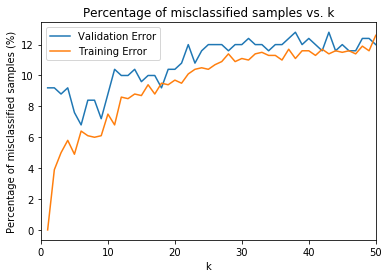

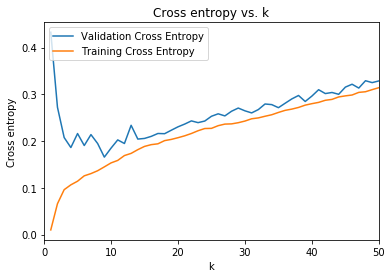

In [168]:
kf = KFold(n_splits=5, shuffle=True)    # 5 fold CV here.
Least_misclassified_samples=float("inf")
ValidationError=[np.nan]                # We initialise lists to store Errors and Log loss
TrainingError=[np.nan]
ValidationLogLoss=[np.nan]
TrainingLogLoss=[np.nan]
for k in range(1,51):                   # We run up to k=50
    Total_training_score=0
    Total_validation_score=0
    training_logloss=0
    validation_logloss=0
    for train, validation in kf.split(Xtr): 
        knn = neighbors.KNeighborsClassifier(n_neighbors=k)
        knn.fit(Xtr[train], ttr[train])                                       # We fit the model for k neighbours
        Total_validation_score += knn.score(Xtr[validation], ttr[validation]) # We score the model
        Total_training_score += knn.score(Xtr[train], ttr[train])
        
        #We consider log loss
        ptr = knn.predict_proba(Xtr[train])[:,1]                            # We then consider the log loss
        pva = knn.predict_proba(Xtr[validation])[:,1]
        
        training_logloss += metrics.log_loss(ttr[train], ptr,eps=0.01)
        validation_logloss += metrics.log_loss(ttr[validation], pva,eps=0.01)
    
    #We find the mean logloss over the training and validation sets
    TrainingLogLoss.append(training_logloss/5)
    ValidationLogLoss.append(validation_logloss/5)       
        
    Training_score = Total_training_score/5
    Validation_score = Total_validation_score/5
    Percentage_misclassified_samples = (1-Validation_score)*100
    if Percentage_misclassified_samples<Least_misclassified_samples:     # If the percentage of misclassified samples is the lowest seen, we save the value of k
        best_k=k
        Least_misclassified_samples=Percentage_misclassified_samples
    ValidationError.append(Percentage_misclassified_samples)  
    TrainingError.append((1-Training_score)*100)
    

# Plotting commands
    
plt.plot(ValidationError,label='Validation Error')
plt.plot(TrainingError,label='Training Error')
plt.legend(loc='upper left')
plt.xlim(0,50)
plt.xlabel('k')
plt.ylabel('Percentage of misclassified samples (%)')
plt.title('Percentage of misclassified samples vs. k')
print('The best value of k=%i' % (best_k))
plt.figure()
plt.plot(ValidationLogLoss,label='Validation Cross Entropy')
plt.plot(TrainingLogLoss,label='Training Cross Entropy')
plt.legend(loc='upper left')
plt.xlim(0,50)
plt.xlabel('k')
plt.ylabel('Cross entropy')
plt.title('Cross entropy vs. k')



We see that the optimum k tends to be fairly small for our dataset (normally ~1-10). As k increases past the small values, the training and validation errors both also increase.

It is also worth noting that the classification is better for odd values of k than even values of k. This is due to there being a possibility of ties that need to broken if k is even (as we only have 2 classes this is only a possibility if k is even). The validation error tends to exceed the training error, as this fold of the data is used purely for validation, whilst the training folds are used when developing the classifier.

We also calculate the cross entropy, which uses the probabilities given features [X1,X2], that the target variable is t=1. We then calculate the log loss using the target data and the probability estimated by the classifier. One key difference is that log loss uses probabilities, whereas if P(t=1)>0.5 in the model, we classify it as class 1, or else we classify it as class 2. Log loss therefore considers the uncertainty of the model, which is not taken into account in a simple percentage of misclassified samples graph.

We observe other differences between the cross entropy and the percentage of misclassified samples:

The cross entropy tends to be much smoother than the percentage of misclassified errors, as if we have 5 validation sets of 50 datapoints each (if the number of folds in k-fold cross validation = 5), then our percentage of misclassified samples can only take discrete values in intervals of 0.4% (as 250 total validation samples are used across all folds). Whereas with the cross-entropy, as we are considering probabilities on a continuous spectrum (between 0 and 1), cross entropy values can take any value, for a given k.

As log loss is undefined at 0 and 1 (as log(0) is undefined), we must introduce a clipping variable. Log loss punishes heavily if the classifier is certain about a sample but misclassifies it. This acts to make our log loss extremely large, even if we only misclassify a few samples, if the classifier is certain and wrong. To minimise the impact of this, we choose a large value for our clipping parameter (eps=0.01), so probabilities are clipped to max(eps, min(1 - eps, p)), where p is the probability of the target value being 1. 

Despite this, our cross entropy of the validation set remains high at low values of k, due to it predicting every sample with certainty. Aside from this, the validation and training cross entropies vs. k graph roughly mirror the percentage of misclassified samples vs. k graph (for higher values of k).

*  What is the error on the **test** set with the best $k$?

We calculate performance on the test set by refitting the knn classifier, using our choice of the optimum k, on the whole training set. Then we calculate the test score, and the corresponding percentage error.

In [169]:
# we calculate performance on the test set
knn = neighbors.KNeighborsClassifier(n_neighbors=best_k)
knn.fit(Xtr, ttr)
Test_score=knn.score(Xte,tte)
Percentage_misclassified_samples = (1-Test_score)*100
print('Percentage of misclassified samples (error) on the test set=%f%%, using the best k (k=%i).' % (Percentage_misclassified_samples,best_k))



Percentage of misclassified samples (error) on the test set=9.200000%, using the best k (k=6).


We see the percentage error is quite high (normally roughly 7-10%) depending on the value of k). There is some variance in the performance of this classifier, as it depends on the splits in the k-fold cross validation.

*  Make a plot of the decision regions (as above) with the best $k$

The graphs below show the decision regions of the k-nearest neighbours algorithm on our dataset, where k is the best k (k=6).


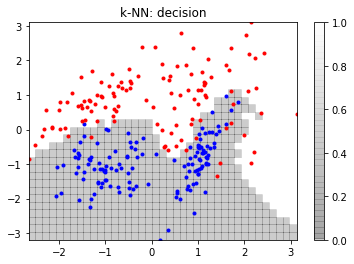

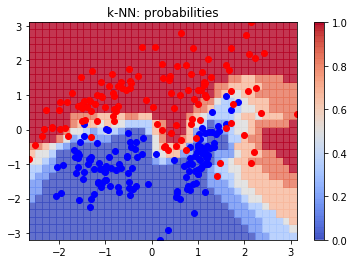

In [170]:
print('The graphs below show the decision regions of the k-nearest neighbours algorithm on our dataset, where k is the best k (k=%i).'%(best_k))
plot_decision_regions(Xtr, ttr, model=knn, label='k-NN')

*  What can you say about the performance of the classifier when $k$ is too large or too small? 

If the value of k in k nearest neighbours is too large, the classifier becomes inaccurate, as we consider too many points that are not necessarily local to the point which is being classified in the feature space. Furthermore, using a large k is computationally expensive, as we have to consider more distances from any given point.  If the features which are being used for k-nearest neighbours are relevant to classification, it follows that once k increases past a certain optimal k, too much of the dataset is being considered. 

On the other hand, if the value of k chosen is too small we run the risk of one/a few outliers affecting the performance of our classifier (making the classifier inaccurate). Hence, the classifier also performs poorly if we choose a k that is too small.

*  How do you think the optimum $k$ will vary if the amount of training data available is larger or smaller than 250 points?  Can you test your hypothesis?

If we have a sufficiently large training dataset, there will be good coverage of the feature space. Therefore training sets will have more relevant points to aid with classification. Hence, we should consider more data when we have a larger training dataset, as there will be greater amount of data points local to the classified sample, so there is more relevant data which can be used for classification (less distance between points in the feature space, where we assume that features are relevant to classification). Also the classifier will then be less influenced by outliers. Hence, in the case where we have a large training set, we should expect the optimum k to increase.

Conversely, we expect that the optimum k will decrease if the dataset is smaller, as a result of the feature space being less 'well covered' by the training data. Hence, any classified sample will have less relevant data points local to itself in the feature space. So a smaller k is more suitable for a smaller training datasets, whilst a larger k is optimum for a larger training dataset.

It is possible that all points in the feature space are a poor representitive of the points which we are classifying if the dataset is extremely small. This leads to greater variance and more randomness. Hence, we would expect the mean optimum value of k to tend upwards as we reach extremely small values of k, due to variance in the choice of validation and training sets (in k-fold).

We test this hypothesis below by reducing or increasing the proportion of data used for training the model. We vary the size of the training dataset between 100 data points and 400 data points (originally we used 250) in increments of 50. We then train the model 100 times for each training set and find the mean and the sample variance of the optimum values of k observed.

<font color="red">**Warning: This cell takes ~10 minutes to run.**</font>:

<div style="text-align: right"><b>[10 marks]</b></div>

Text(0, 0.5, 'Sample variance of best k')

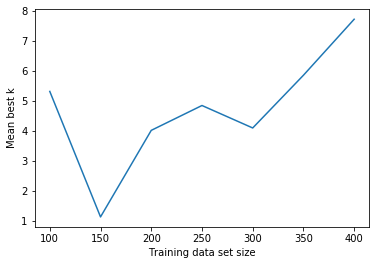

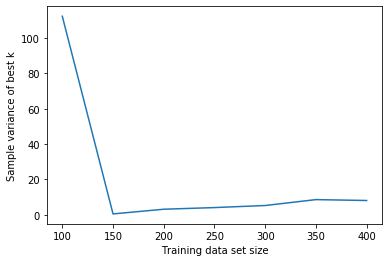

In [171]:
I = range(len(tall))
training_data_set_size=[]  # Create lists for storing
mean_best_ks=[]
var_best_ks=[]
kf = KFold(n_splits=5, shuffle=True) # kfold

for j in range(2,9): #We range from 100-400 training data size
    best_ks=[]
    Itrain = I[:j*len(tall)//10]
    Xtr_variable = Xall[Itrain,:]
    ttr_variable = tall[Itrain]
    for i in range(100): #We run each size of set 100 times and take the mean
        Least_misclassified_samples=float("inf")
        for k in range(1,81):     #We range k from 1-80 (max possible k for size = 100 (as splits into 80/20 split))
            Total_training_score=0
            Total_validation_score=0
            for train, validation in kf.split(Xtr_variable):
                knn = neighbors.KNeighborsClassifier(n_neighbors=k)
                knn.fit(Xtr_variable[train], ttr_variable[train])
                Total_validation_score += knn.score(Xtr_variable[validation], ttr_variable[validation])
            Validation_score = Total_validation_score/5
            Percentage_misclassified_samples = (1-Validation_score)*100
            if Percentage_misclassified_samples<Least_misclassified_samples:
                best_k=k
                Least_misclassified_samples=Percentage_misclassified_samples
        best_ks.append(best_k)
    mean_best_ks.append(np.mean(best_ks))
    var_best_ks.append(np.var(best_ks,ddof=1))
    training_data_set_size.append(len(tall)*j/10)
    
#Plotting
    
plt.plot(training_data_set_size,mean_best_ks)
plt.xlabel('Training data set size')
plt.ylabel('Mean best k')
plt.figure()
plt.plot(training_data_set_size,var_best_ks)
plt.xlabel('Training data set size')
plt.ylabel('Sample variance of best k')

As we see above, our hypothesis was correct. 

Initially, when the size of the training dataset is very small (~100), we observe a larger mean best k. As we can see in the plot of the sample variance, the mean is impacted by a large variance in the values of the optimum k selected. This variance acts to increase the mean. This is because when k is small, variance in the validation and training sets can lead to a poor classification of the model. In this instance, even considering the nearest ~50-65% of the data points can sometimes result in the best classifier, so sometimes the model chooses extremely high values of k as optimal (sometimes up to k$\approx$50 for a training set size of 100 (splits of 80/20 training/validation)).

We also observe that, excluding this large variance in the values of the optimum k for extremely small datasets, there is a trend that as the size of the dataset increases (from 150 to 400), the mean optimum k selected also tends to increase (as expected). 

### 1.2 Multi-layer perceptrons (MLP)

Multi-layer perceptrons are the sorts of neural networks that have been described in lectures.  In this section we'll use an MLP with weight decay regularisation to classify the same data again. 

The next cell sets up an MLP with 5 hidden units and the given regularisation constant ($\alpha$), trains it a few times from random starting places to find the best minimum (because $E(\mathbf{w})$ may have local minima) and uses it to classify points on a grid as above.

Experiment with different values of the regularisation constant, plotting the decision boundaries to visualise how the regularisation forces a smooth or more wiggly boundary.  Remember to vary $\alpha$ on a logarithmic scale and it could range between $10^{-16}$ (effectively 0) and $1$. 

<div style="text-align: right"><b>[5 marks]</b></div>

We vary $\alpha$ from $10^{-16}$ (effectively 0), to $10^{-2}$, $10^{-1}$, $1$, and $10$, to see the effect of the regularisation constant on the decision regions:

Performance with alpha=1e-16 
	- on training set 0.972000 
	- on test set 0.904000
Performance with alpha=0.01 
	- on training set 0.968000 
	- on test set 0.884000
Performance with alpha=0.1 
	- on training set 0.976000 
	- on test set 0.916000
Performance with alpha=1 
	- on training set 0.920000 
	- on test set 0.904000
Performance with alpha=10 
	- on training set 0.892000 
	- on test set 0.880000


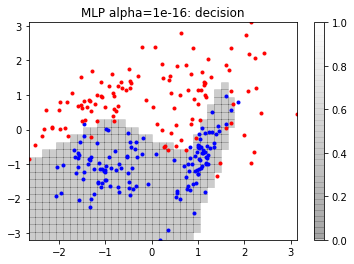

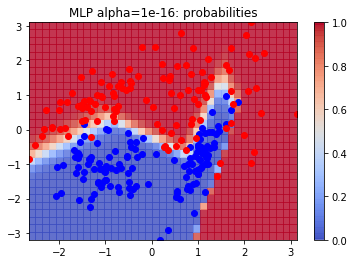

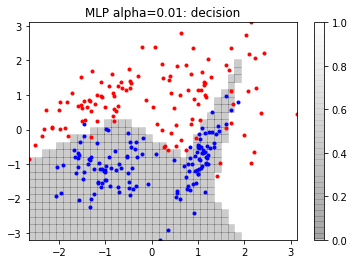

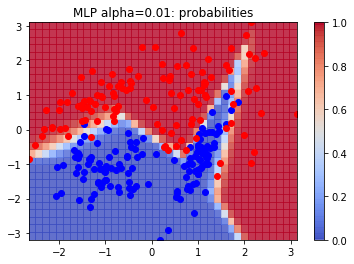

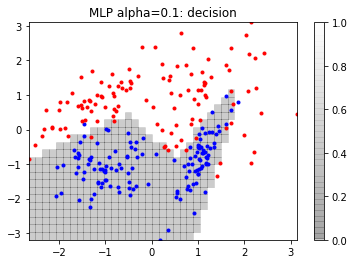

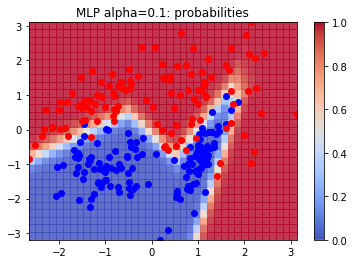

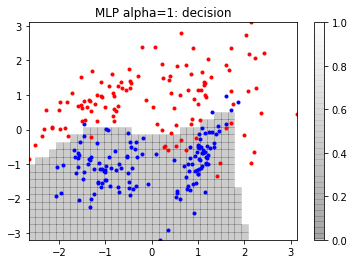

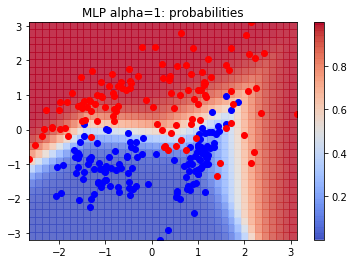

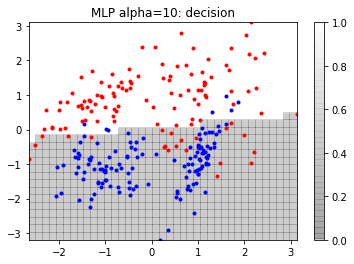

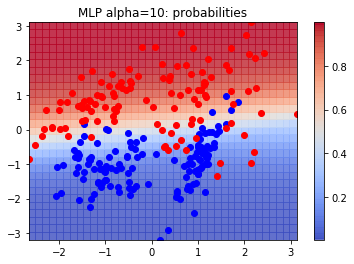

In [172]:
#We then vary alpha (near 0 (10^-16),0.01,0.1,1,10)
alpha=[1e-16,1e-2,1e-1,1,10]
for j in range(len(alpha)): # We run for all alphas
    Ebest = np.Inf
    for n in range(10): #We take the best model (according to validation error) in 10 runs
        mlp = MLPClassifier(solver='lbfgs', alpha=alpha[j], hidden_layer_sizes=(5,))
        mlp.fit(Xtr, ttr)
        if mlp.loss_ < Ebest:
            mlpbest = mlp
            Ebest = mlp.loss_
    mlp = mlpbest


    plot_decision_regions(X=Xtr, t=ttr, model=mlp, label='MLP alpha='+str(alpha[j]), show_decision=True, show_probabilities=True)

    Ste = mlp.score(Xte, tte)
    Str = mlp.score(Xtr, ttr)
    print('Performance with alpha='+str(alpha[j])+' \n\t- on training set %f \n\t- on test set %f' % (Str, Ste))


$\alpha$ (the regularisation constant) punishes models for being overly complex. As we see above, at lower values of $\alpha$ there is almost no regularisation. Hence, we see very wiggly boundaries in the plot of the decision regions. As we increase $\alpha$ (with a constant 5 hidden units), we see that it enforces a smoother boundary. As we increase $\alpha$ to 1, the boundary is very smooth. As we reach $\alpha$=10, the boundary becomes an almost linear partition of the two decision regions (this model underfits the data).

Use cross-validation to choose the best value of the regularisation constant for these data.   Plot the training and validation data errors versus $\alpha$.  How well does the validation error correspond to the actual test error?

<div style="text-align: right"><b>[5 marks]</b></div>

We use k-fold cross-validation to choose the best value of the regularisation constant. We can also find the test error at each $\alpha$ by fitting the model using all of the training data. Here we vary $\alpha$ in powers of 10 to find the optimum:

The best value of alpha=1e^-1


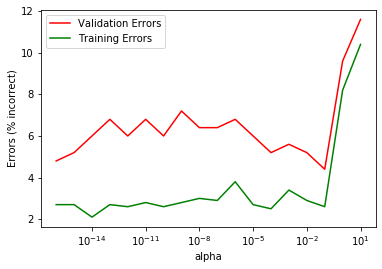

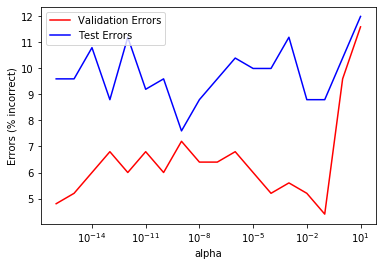

In [173]:
a=randint(0, 2**31)
kf = KFold(n_splits=5, shuffle=True, random_state=a)  #Kfold
Validation_Errors=[]
Training_Errors=[]
Test_Errors=[]
best_va_error = np.Inf
alpha = [pow(10, i) for i in range(-16,2)]
for j in range(len(alpha)): # We run across all alphas
    total_tr_error=0
    total_va_error=0
    for train, validation in kf.split(Xtr): # We run across all folds
        Ebest = np.Inf
        for n in range(10):
            mlp = MLPClassifier(solver='lbfgs', alpha=alpha[j], hidden_layer_sizes=(5,))
            mlp.fit(Xtr[train], ttr[train])
            if mlp.loss_ < Ebest:  # We minimise loss
                mlpbest = mlp
                Ebest = mlp.loss_
        mlp = mlpbest
        total_tr_error += 1-mlp.score(Xtr[train], ttr[train])
        total_va_error += 1-mlp.score(Xtr[validation], ttr[validation])
    tr_error=(total_tr_error/5)*100
    va_error=(total_va_error/5)*100
    if va_error<best_va_error: # If the error is the least yet, we store it and the power of alpha
        best_va_error=va_error
        best_alpha=j-16        

    Training_Errors.append(tr_error)
    Validation_Errors.append(va_error)
    
#We can then find the test error at each alpha by using the whole training set

for j in range(len(alpha)): 
    Ebest = np.Inf
    for n in range(10):
        mlp = MLPClassifier(solver='lbfgs', alpha=alpha[j], hidden_layer_sizes=(5,))
        mlp.fit(Xtr, ttr)
        if mlp.loss_ < Ebest:
            mlpbest = mlp
            Ebest = mlp.loss_
        mlp = mlpbest
    te_error = (1-mlp.score(Xte,tte))*100
    Test_Errors.append(te_error)
    
# Plotting  
plt.plot(alpha,Validation_Errors,'r',label='Validation Errors')
plt.plot(alpha,Training_Errors,'g',label='Training Errors')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Errors (% incorrect)')
plt.legend(loc='upper left')
plt.figure()
plt.plot(alpha,Validation_Errors,'r',label='Validation Errors')
plt.plot(alpha,Test_Errors,'b',label='Test Errors')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Errors (% incorrect)')
plt.legend(loc='upper left')
print('The best value of alpha=1e^%i' % (best_alpha))

We note that the best value of the regularisation constant $\alpha$ is highly variable depending on the seed (which is randomly generated). This is because the values of $\alpha$ are actually varying by very small amounts (the difference between $\alpha$=$10^{-16}$ and $\alpha$=$10^{-2}$ is very small in comparison to the difference in regularisation between $\alpha$=$10^{-2}$ and $\alpha$=$10$). This is visualised in the difference between the decision regions (there is little difference between the decision regions for very small values of $\alpha$, e.g. $\alpha$=$10^{-16}$ and $\alpha$=$10^{-2}$). However, we do see a large difference as $\alpha$ increases to $1$ and $10$, where the error increases on the validation, test and training data. This is because $\alpha$=$10$ underfits the classification problem, so a more complex model would improve classification.

Again, similarly to k nearest neighbours, we see there is quite a high test error (~8-12% depending on the value of $\alpha$ and the models selected).

The validation error does roughly follow the shape of the test error, however the validation error is much lower than that of the test error. This is because there is some selection bias, as we aim to minimise the value of the validation error, so we take the minimal validation error in 10 random models. Naturally, this causes the validation error to be minimised. However, as the test data remains unseen, the model is selected with no information about the errors on the test data (even though the selection bias on the validation set acts to reduce the test error, as the validation data hopefully roughly mirrors the distribution of the test data). Hence, this discrepancy between the test and validation errors is as expected.

Bonus question:  How should the best value of $\alpha$ vary as the number of training examples is increased? Why? Can you test it? 

<div style="text-align: right"><b>[5 marks]</b></div>

We regularise to avoid overfitting, so we should regularise more for smaller training datasets and less for larger training datasets, as it is easier to overfit a small training dataset (as a single outlier will have a greater influence on model selection when the training dataset is small). Whilst with a larger training dataset, we are less prone to overfitting. Hence, in theory we expect that $\alpha$ should decrease if the number of training examples is increased, as there is less need to prevent overly complex models (regularise).

Similarly to our test for k nearest neighbours, we test this hypothesis below by reducing or increasing the proportion of data used for training the model. We vary the size of the training dataset between 100 data points and 400 data points (originally we used 250) in increments of 50. We then train the model 100 times for each training set and find the mean of the optimum values of k that we observe. We let $\alpha$ take values $10^{-16}$, $10^{-5}$, $10^{-4}$, $10^{-3}$, $10^{-2}$, $10^{-1}$, $1$, as there is little difference in regularisation between small values of $\alpha$, and we know $\alpha$=$10$ underfits the data. 

<font color="red">**Warning: This cell takes ~2.5 hours to run.**</font>:


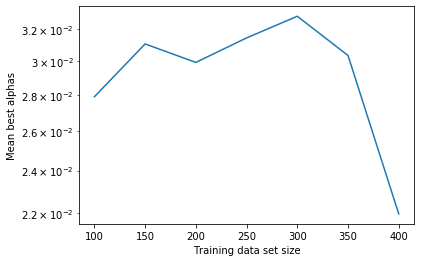

In [22]:
a=randint(0, 2**31)
kf = KFold(n_splits=5, shuffle=True, random_state=a)  
I = range(len(tall))
training_data_set_size=[]
mean_best_alphas=[]
alpha = [1e-16,1e-5,1e-4,1e-3,1e-2,1e-1,1]
for j in tqdm(range(2,9)):  # We run across different sizes of training sets (100-400)
    Itrain = I[:j*len(tall)//10]
    Xtr_variable = Xall[Itrain,:]
    ttr_variable = tall[Itrain]
    best_alphas=[]
    for i in tqdm(range(100)): # We run each 100 times and find a mean
        best_va_error=float("inf")
        for k in range(len(alpha)): # We run over all possible alphas
            total_va_error=0
            for train, validation in kf.split(Xtr): # And all folds
                Ebest = np.Inf
                for n in range(10): # We take the best model
                    mlp = MLPClassifier(solver='lbfgs', alpha=alpha[k], hidden_layer_sizes=(5,))
                    mlp.fit(Xtr[train], ttr[train])
                    if mlp.loss_ < Ebest:
                        mlpbest = mlp
                        Ebest = mlp.loss_
                mlp = mlpbest
                total_va_error += 1-mlp.score(Xtr[validation], ttr[validation])
            va_error=(total_va_error/5)*100
            if va_error<best_va_error: 
                best_va_error=va_error
                best_alpha=alpha[k]  
        best_alphas.append(best_alpha)
    mean_best_alphas.append(np.mean(best_alphas)) # We save the mean for a specific training set size
    training_data_set_size.append(len(tall)*j/10)
plt.plot(training_data_set_size,mean_best_alphas)
plt.xlabel('Training data set size')
plt.ylabel('Mean best alphas')
plt.yscale('log')

We do not observe the expected results in this case (as all mean best $\alpha$s are broadly similar, so we cannot draw a conclusion from this). This could be for a variety of reasons: e.g. excessive noise in the dataset, not running enough iterations of the model selection (our choice for this is n=10), or insufficient hidden layers (we only choose 5 hidden layers).

### 1.3. Support Vector Machines (SVM)

Support vector machines (SVMs) are popular and powerful classifiers.  We'll deal with them in detail later in the module.  In the following you will use SVMs with both a "linear kernel" and with a RBF kernel.  With a linear kernel the SVM can only separate the classes with a straight line or a (hyper)plane, but an RBF kernel is nonlinear and allows the SVM to generate curved decision boundaries.  


We'll use the support vector machines in scikit learn.  Here's an example of training a SVM using a linear kernel (i.e., no non-linearity).

Performance:
	- on training set 0.904000 
	- on test set 0.880000


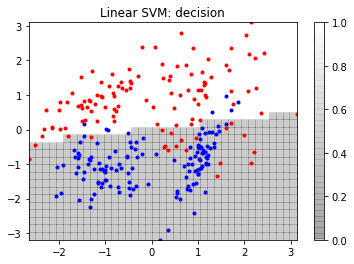

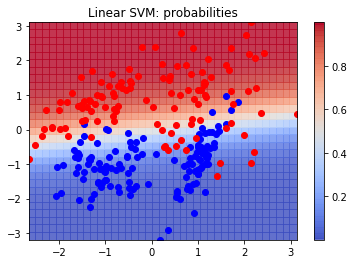

In [174]:
svm = SVC(kernel='linear', probability=True)    # SVM with a linear kernel, 
                                                # note that enabling probabilities is slower
svm.fit(Xtr, ttr)                     # Train it on the training data

plot_decision_regions(X=Xtr, t=ttr, model=svm, label='Linear SVM', show_decision=True, show_probabilities=True)

Ste = svm.score(Xte, tte)
Str = svm.score(Xtr, ttr)
print('Performance:\n\t- on training set %f \n\t- on test set %f' % (Str, Ste))


Now use the SVM with <code>kernel='rbf'</code> to classify the data, but with a non-linear mapping so that the decision boundary can be non-linear. 

In this case the SVM has two additional parameters $C > 0$ and $\gamma$.  $C$ is a regularisation constant that controls how strongly points that lie on the wrong side of the decision boundary are penalised.  When $C$ is large, they are heavily penalised which results in the boundary being flexible, but when it is small they are lightly penalised so the boundary tends to be straighter.  You can set the value of $C$ (and $\gamma$) with

        svm = SVC(kernel='rbf', C=1, gamma=0.1) 

The default value of $C$ is 1 and the default value of $\gamma$ is 0.1.

Performance with C=1.000000, gamma=0.100000,
	- on training set 0.888000 
	- on test set 0.868000


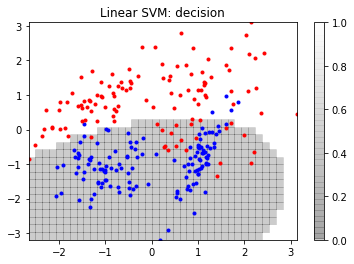

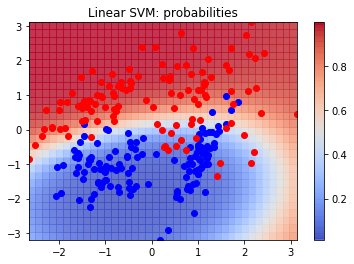

In [175]:
svm = SVC(kernel='rbf', C=1, gamma=0.1, probability=True)            # SVM with a RBF kernel
svm.fit(Xtr, ttr)                     # Train it on the training data

plot_decision_regions(X=Xtr, t=ttr, model=svm, label='Linear SVM', show_decision=True, show_probabilities=True)

Ste = svm.score(Xte, tte)
Str = svm.score(Xtr, ttr)
print('Performance with C=%f, gamma=%f,\n\t- on training set %f \n\t- on test set %f' % (1, 0.1, Str, Ste))


The $\gamma$ parameter controls the width of the RBF kernel, that is how close training samples must be to interact with each other.  When $\gamma$ is large the training samples must be close to interact and the decision boundary tends to be nonlinear, whereas when $\gamma$ is small it tends to be smooth.

Use cross validation on the *training* data to choose the best value of $C$ and $\gamma$.  Try a few values of $C$ and $\gamma$ by hand first of all to find appropriate ranges and it will  be best to vary them on a logrithmic scale.  You may care to investigate and use the sklearn helper functions for searching a grid of values for the best cross validation value: see <http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#example-svm-plot-rbf-parameters-py> or write your own!

What is the resulting accuracy on the test data and the best decision boundary?

<div style="text-align: right"><b>[15 marks]</b></div>

We use k-fold cross validation and GridSearchCV on the training data to determine the best values of C and $\gamma$:

The best parameters are {'C': 10, 'gamma': 1} with a score of 0.96


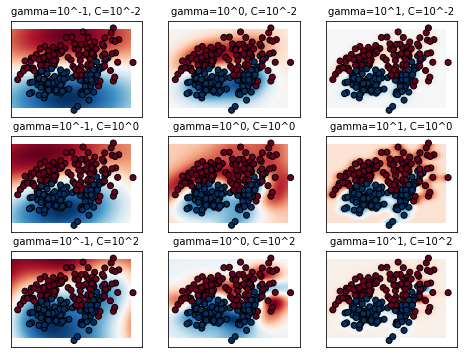

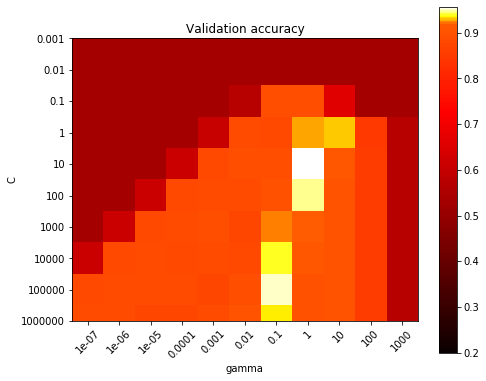

In [176]:
a=randint(0, 2**31)
kf = KFold(n_splits=5, shuffle=True, random_state=a)

C_range = [pow(10, i) for i in range(-3,7)]
gamma_range = [pow(10, i) for i in range(-7,4)]
param_grid = dict(gamma=gamma_range, C=C_range)
grid = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid, cv=kf) #We find the best param values using gridsearchcv
grid.fit(Xtr, ttr) #We then fit the model

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

# Code for plotting figures from sklearn documentation

C_2d_range = [1e-2, 1, 1e2]
gamma_2d_range = [1e-1, 1, 1e1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(kernel='rbf',C=C, gamma=gamma)
        clf.fit(Xtr, ttr)
        classifiers.append((C, gamma, clf))

plt.figure(figsize=(8, 6))
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
for (k, (C, gamma, clf)) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)),
              size='medium')

    # visualize parameter's effect on decision function
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(Xtr[:, 0], Xtr[:, 1], c=ttr, cmap=plt.cm.RdBu_r,
                edgecolors='k')
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

As we can see, we have found the optimum values of C and $\gamma$, as visualised in the plots. The value of C selected sometimes varies (dependent on the random folds in k-fold cross validation). As we see in the plot of validation accuracy, C=100000, $\gamma$=0.1 are valid choices for our parameters. C=10 or 100, $\gamma$ = 1 (and surrounding cells) are also valid choices for our parameters.

We then train this (using the optimum parameters found) on the entire training data and find how well it classifies the test data. We also plot the decision regions of the classifier:

Performance with C=10.000000, gamma=1.000000,
	- on training set 0.964000 
	- on test set 0.928000


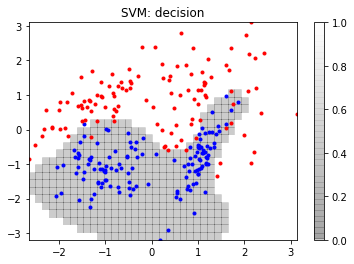

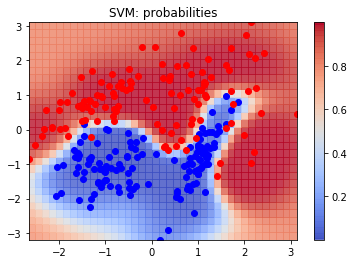

In [177]:
svm = SVC(kernel='rbf', C=grid.best_params_['C'], gamma=grid.best_params_['gamma'], probability=True)    # SVM with a RBF kernel
svm.fit(Xtr, ttr)                     # Train it on the training data

plot_decision_regions(X=Xtr, t=ttr, model=svm, label='SVM', show_decision=True, show_probabilities=True)

Ste = svm.score(Xte, tte)
Str = svm.score(Xtr, ttr)
print('Performance with C=%f, gamma=%f,\n\t- on training set %f \n\t- on test set %f' % (grid.best_params_['C'],grid.best_params_['gamma'], Str, Ste))


As we see above, the performance of this classifier is slightly better than the other models (depending on which C and $\gamma$ are selected, we obtain ~91-93% successful classification- a 7-9% misclassification rate). There is some variance in the performance of this classifier, as depending on the split in the k-fold cross validation, we obtain different parameter choices for C and $\gamma$.

## Part 2: Digits dataset

In the second part, we will experiment with the same algorithm on a more complex dataset: examples images of hand-written digits. For this we will use a standard dataset provided by sklearn: <i>digits</i>

(1797, 64)
[0 1 2 3 4 5 6 7 8 9]


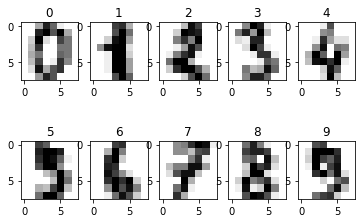

In [178]:
# (note: we overwrite the previous data here, make sure to reload it if you go back to part 1)
Xall, tall = datasets.load_digits(return_X_y=True)

print(Xall.shape)
print(np.unique(tall))

# print some examples of data from the dataset
for j in range(10):
    plt.subplot(2,5,j+1)
    plt.imshow(np.reshape(Xall[j,:], (8,8)), cmap=plt.cm.gray_r)
    plt.title("%d" % tall[j])
plt.show()

As you can see there are 1797 images arranged as 64-dimensional vectors, and defining 10 classes. In this case, the observed variables have many more dimensions, but we can use <i>multidimensional scaling</i> to visualise the distribution of the classes somehow (note that MDS on a large dataset can take a while).  

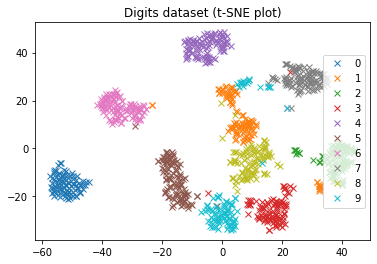

In [179]:
# we select a subset of samples for speed 
Ntrain=1000
J = np.random.permutation(Xall.shape[0])[:Ntrain]
X = Xall[J,:]
t = tall[J]   # Features

# we then optimise the multidimensional scaling 
tsne = TSNE()
Xe = tsne.fit_transform(X)

# we then draw the classes on a 2D plot
for i in range(10):
    plt.plot(Xe[t==i,0], Xe[t==i,1], 'x', label='{}'.format(i))
plt.legend(loc='right')
plt.title('Digits dataset (t-SNE plot)')
plt.show()

This means that you have problem of <b>multiclass</b> classification. Some algorithms such as k-NN or MLPs can handle multiclass, whereas some other such as SVM need some additional work. 

In [180]:
#Example with k-NN:  

I = range(len(tall))    # you could change this for np.random.permutation(len(tall)) to get a random selection
                        # do not do this for this workshop as I want to be able to compare final performance. 

Itrain = I[:len(tall)//2]   # First half of indices for training
Itest = I[len(tall)//2:]    # Second half for test

Xtr = Xall[Itrain,:] # we define variables for the training set...
ttr = tall[Itrain]   

Xte = Xall[Itest,:]  # ... and for the test set
tte = tall[Itest]   

k = 5   # Choose the number of nearest neighbours

knn = neighbors.KNeighborsClassifier(n_neighbors=k)
knn.fit(Xtr, ttr)

# we can get the performance on the training set
Str = knn.score(Xtr, ttr)

# we can also calculate the performance on the test set: 
Ste = knn.score(Xte, tte)

print('Performance with k=%i,\n\t- on training set %f \n\t- on test set %f' % (k, Str, Ste))


Performance with k=5,
	- on training set 0.988864 
	- on test set 0.955506


In a multiclass setting it is often worth calculating another error measure: the confusion matrix. This matrix tells you where your error comes from and whether two classes are specially confused.  

<font color="red">**Please rerun any cells containing confusion matrices if they do not show up well, it is caused by a bug with my version of matplotlib (3.1.1). However, if you are using a different version it should work when you rerun the cell.**</font>:

Confusion matrix, without normalization
[[88  0  0  0  0  0  0  0  0  0]
 [ 0 89  0  0  0  0  0  0  1  1]
 [ 1  0 80  5  0  0  0  0  0  0]
 [ 0  0  1 82  0  2  0  3  2  1]
 [ 0  0  0  0 87  0  0  1  0  4]
 [ 0  0  0  0  0 89  1  0  0  1]
 [ 0  0  0  0  0  0 91  0  0  0]
 [ 0  0  0  0  0  0  0 89  0  0]
 [ 0  5  1  1  0  0  0  1 79  1]
 [ 0  0  0  4  0  2  0  0  1 85]]


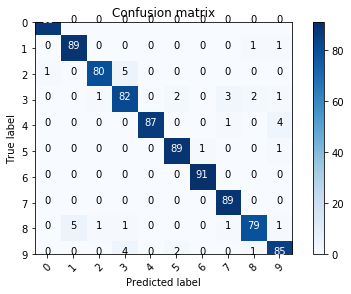

In [181]:
# we predict the classes on the test data
pte = knn.predict(Xte)

# and we calculate the confusion matrix
cm = confusion_matrix(tte, pte)

np.set_printoptions(precision=2)


# code from: https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
# now included in sklearn 0.22

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plot_confusion_matrix(cm, np.unique(tte))

### 2.1 Digits with knn 
As a first shot, we will use the k-NN algorithm to try and model this dataset.
As we did before, use k-fold cross validation to find the best value of $k$. 
<div style="text-align: right"><b>[5 marks]</b></div>

As before, we implement k-fold cross validation to find the best value of $k$:

The best value of k=1


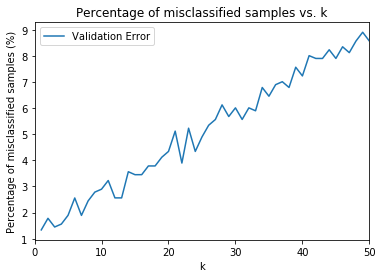

In [192]:
kf = KFold(n_splits=5, shuffle=True)    # 5 fold CV here.
Least_misclassified_samples=float("inf")
Error=[np.nan]
for k in range(1,51): # We run across all ks
    Total_training_score=0
    Total_validation_score=0
    for train, validation in kf.split(Xtr): # We run across all folds
        knn = neighbors.KNeighborsClassifier(n_neighbors=k)
        knn.fit(Xtr[train], ttr[train])
        Total_validation_score += knn.score(Xtr[validation], ttr[validation])
    Validation_score = Total_validation_score/5
    Percentage_misclassified_samples = (1-Validation_score)*100
    if Percentage_misclassified_samples<Least_misclassified_samples: # If it is the best k we've seen we save it
        best_k=k
        Least_misclassified_samples=Percentage_misclassified_samples
    Error.append(Percentage_misclassified_samples)   
    
# Plotting
plt.plot(Error,label='Validation Error')
plt.xlim(0,50)
plt.xlabel('k')
plt.ylabel('Percentage of misclassified samples (%)')
plt.title('Percentage of misclassified samples vs. k')
plt.legend(loc='upper left')
print('The best value of k=%i' % (best_k))

After we pass the initial small values of k, we observe a near linear (with lots of noise) relationship between the percentage of misclassified samples in the validation set. 

The best value of k varies depending upon the split used in the k-fold cross validation. Typical values are very small for the optimum k, ranging from ~1-5.

Calculate the confusion matrix for the best parameter, show some examples of the misclassifications and try to explain the remaining errors. 
<div style="text-align: right"><b>[5 marks]</b></div>

We refit the model on the entire training set, then we calculate the performance on the test set and the confusion matrix and show some examples of misclassifications:

Performance with k=1:
	- on training set 1.000000 
	- on test set 0.961068
Confusion matrix, without normalization
[[87  0  0  0  1  0  0  0  0  0]
 [ 0 88  1  0  0  0  0  0  2  0]
 [ 1  0 83  2  0  0  0  0  0  0]
 [ 0  0  0 84  0  2  0  1  2  2]
 [ 0  0  0  0 87  0  0  0  0  5]
 [ 0  0  0  0  0 89  1  0  0  1]
 [ 0  0  0  0  0  0 91  0  0  0]
 [ 0  0  0  0  0  0  0 88  1  0]
 [ 0  4  0  2  0  0  0  0 81  1]
 [ 0  0  0  4  0  2  0  0  0 86]]


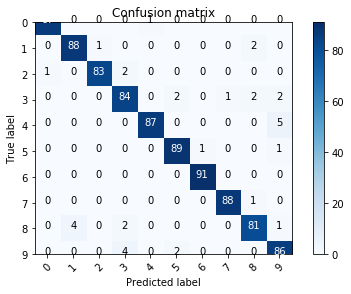

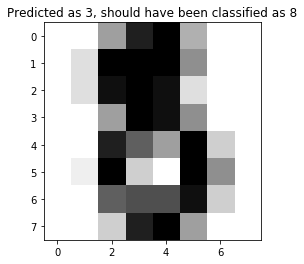

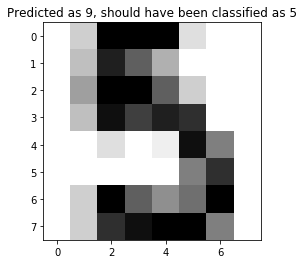

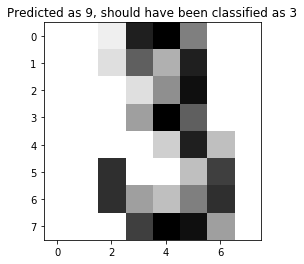

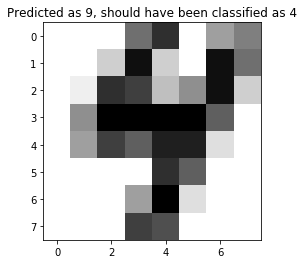

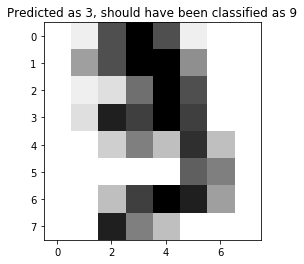

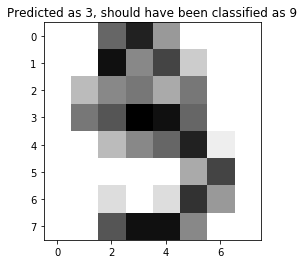

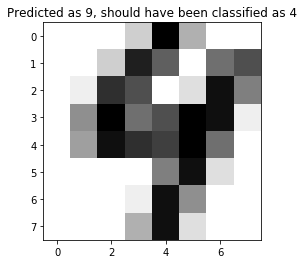

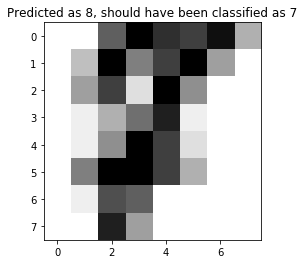

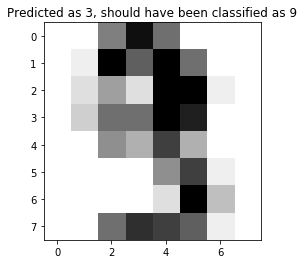

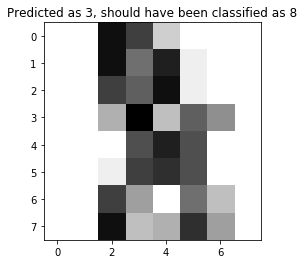

In [198]:
#we refit using ALL training data on the best k:
knn = neighbors.KNeighborsClassifier(n_neighbors=best_k)
knn.fit(Xtr, ttr)

#we find the scores
knn_tr=knn.score(Xtr,ttr)
knn_te=knn.score(Xte,tte)

print('Performance with k=%i:\n\t- on training set %f \n\t- on test set %f' % (best_k, knn_tr, knn_te))# we predict the classes on the test data
pte = knn.predict(Xte)

# and we calculate the confusion matrix
cm = confusion_matrix(tte, pte)
plot_confusion_matrix(cm, np.unique(tte))

# We show the first 10 misclassification examples:
k=1
for j in range(len(tte)):
    if tte[j]!=pte[j]:
        if k<=10:
            plt.figure()
            plt.imshow(np.reshape(Xte[j,:], (8,8)), cmap=plt.cm.gray_r)
            plt.title("Predicted as %d, should have been classified as %d" % (pte[j],tte[j]))
        k+=1
plt.show()


The k nearest neighbours classifier is very accurate for this dataset (ranging from a ~95-97% successful classification rate- a 3-5% misclassification (error) rate on the test set). 

As shown in the confusion matrix, a lot of the errors in classification are caused by number that look similar, e.g. 4 and 9 or 3 and 8. Some people also draw numbers in different ways that look more similar to other numbers. The digits are also very pixelated, causing uncertainty, as an 8x8 grid is very small. Furthermore, if the digit is not centered properly or is tilted at an angle, it can affect both training and classification.

However, there are some misclassified examples that could be classified manually, where it is quite obvious what they should be classified as. Hence, we can still make some improvement on this method.

### 2.2 Digits with MLP
As a second attempt 
As we did before, use k-fold cross validation to train an MLP on this data, optimising regularisation parameter $\alpha$ and the number of hidden units. 
<div style="text-align: right"><b>[10 marks]</b></div>

We train an MLP on this data, and optimise the regularisation parameter $\alpha$ and the number of hidden units using GridSearchCV (using k-fold cross validation).

In [201]:
a=randint(0, 2**31)
kf = KFold(n_splits=5, shuffle=True, random_state=a)  # Kfold
param_grid = {'solver': ['lbfgs'],'alpha': 10.0**np.arange(-4,1), 'hidden_layer_sizes':np.arange(10,40)} 
grid = GridSearchCV(MLPClassifier(), param_grid=param_grid, cv=kf) # We use gridsearchcv to find optimum params
grid.fit(Xtr, ttr) # We fit the model using the params found
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

C:\Users\James\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best parameters are {'alpha': 1.0, 'hidden_layer_sizes': 20, 'solver': 'lbfgs'} with a score of 0.98


A typical choice of $\alpha$ ranges around ~0.1-1 , whilst the number of hidden layers typically ranges from ~13-40. Again, the best values of the parameters vary depending upon the splits in the k-fold cross validation.

Calculate the confusion matrix for the best parameter, show some examples of the misclassifications and try to explain the remaining errors. 
<div style="text-align: right"><b>[5 marks]</b></div>

We then refit the MLP using the best parameters on all of the training data, then calculate the confusion matrix and show some examples of misclassification:

Performance with alpha=1.000000, hidden units=20.000000,
	- on training set 0.997773 
	- on test set 0.932147
Confusion matrix, without normalization
[[84  0  0  0  1  0  3  0  0  0]
 [ 0 82  0  1  0  1  0  0  2  5]
 [ 0  0 84  2  0  0  0  0  0  0]
 [ 0  0  0 77  0  3  0  1  9  1]
 [ 0  0  0  0 83  0  5  0  0  4]
 [ 0  1  0  0  0 83  2  1  2  2]
 [ 0  1  0  0  0  0 90  0  0  0]
 [ 0  0  0  0  1  0  0 87  1  0]
 [ 0  3  0  1  0  3  0  0 80  1]
 [ 1  0  0  0  0  2  0  0  1 88]]


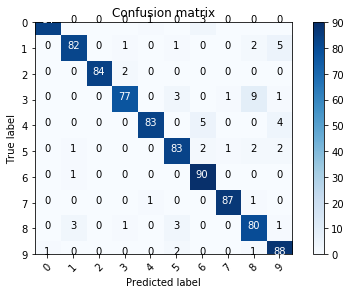

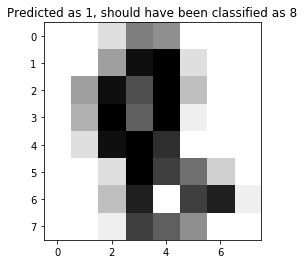

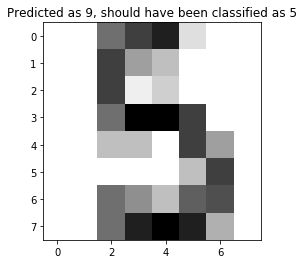

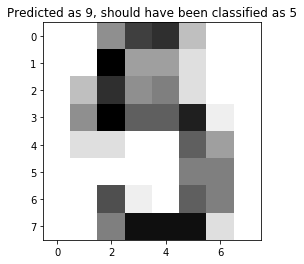

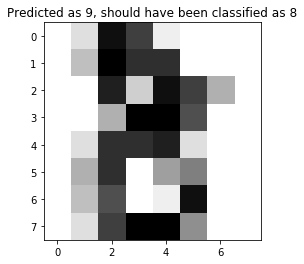

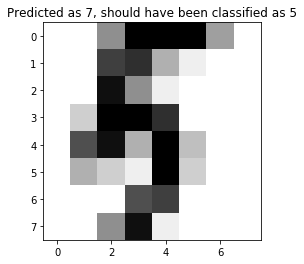

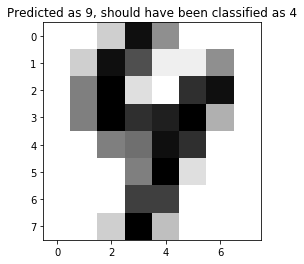

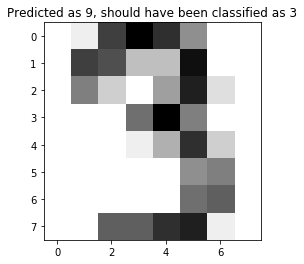

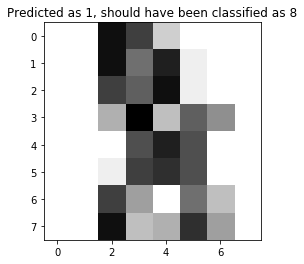

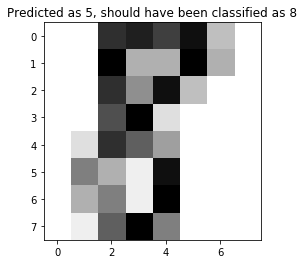

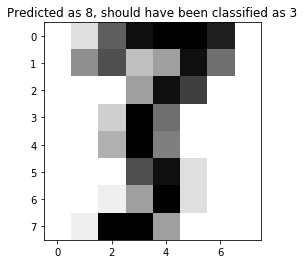

In [202]:
#We refit on all the training data with the best alpha/hidden units and find the best model:
Ebest = np.Inf
for n in range(10):
    mlp = MLPClassifier(solver='lbfgs', alpha=grid.best_params_['alpha'], hidden_layer_sizes=(grid.best_params_['hidden_layer_sizes']))
    mlp.fit(Xtr[train], ttr[train])
    if mlp.loss_ < Ebest:
        mlpbest = mlp
        Ebest = mlp.loss_
mlp = mlpbest

#We calculate scores on the best model
mlp_te = mlp.score(Xte, tte)
mlp_tr = mlp.score(Xtr, ttr)
print('Performance with alpha=%f, hidden units=%f,\n\t- on training set %f \n\t- on test set %f' % (grid.best_params_['alpha'],grid.best_params_['hidden_layer_sizes'], mlp_tr, mlp_te))


# we predict the classes on the test data
pte = mlp.predict(Xte)

# and we calculate the confusion matrix
cm = confusion_matrix(tte, pte)
plot_confusion_matrix(cm, np.unique(tte))

# We show the first 10 misclassification examples:
k=1
for j in range(len(tte)):
    if tte[j]!=pte[j]:
        if k<=10:
            plt.figure()
            plt.imshow(np.reshape(Xte[j,:], (8,8)), cmap=plt.cm.gray_r)
            plt.title("Predicted as %d, should have been classified as %d" % (pte[j],tte[j]))
        k+=1
plt.show()

The MLP classifier we train on this data is quite accurate for this dataset (typically ranging from a ~93-95% successful classification rate- a 5-7% misclassification (error) rate on the test set). 

As shown in the confusion matrix, a lot of the errors in classification are caused by number that look similar, e.g. 3 and 8 or 4 and 9. Some people also draw numbers in different ways that look more similar to other numbers. The digits are also very pixelated, causing uncertainty, as an 8x8 grid is very small. Furthermore, if the digit is not centered properly or is tilted at an angle, it can affect both training and classification. This classifier particularly tends to struggle with differentiating between 9's and 1's more than other classifiers.

Again, there are some misclassified examples that could be classified manually, where it is quite obvious what they should be classified as. Hence, we can still make some improvement on this method.

### 2.3 Digits with SVM 
The last exercise in this workshop will be to use the SVM classifier for this data. In standard, SVMs only allow for binary classification. The standard approach to use them on multiclass problem is to decompose the problem in N 1 vs all classification problem: ie, in this case, this would mean learning one SVM for classifying digit 0 against all other (eg, [1,2,3,4,5,6,7,8,9]), a second classifier for classifying digit 1 against all others, etc. 
The final classification is given by the classifier that yields the strongest confidence. 

This is not too hard to implement, but luckily sklearn implements 1 vs all as standard in the SVC classes. 

Train linear and non linear SVMs, using k-fold cross validation to find the best value for $C$ and $\gamma$. 
<div style="text-align: right"><b>[10 marks]</b></div>

We use GridSearchCV to find the best model for the linear kernel SVM:

In [203]:
a=randint(0, 2**31)
kf = KFold(n_splits=5, shuffle=True, random_state=a) #Kfold

param_grid = {'kernel': ['linear']}
grid = GridSearchCV(SVC(),param_grid=param_grid, cv=kf) 
grid.fit(Xtr, ttr) # We fit the model using a linear kernel

Linear_svm_te = grid.score(Xte, tte)
Linear_svm_tr = grid.score(Xtr, ttr)
print('Performance:\n\t- on training set %f \n\t- on test set %f' % (Linear_svm_tr, Linear_svm_te))

Performance:
	- on training set 1.000000 
	- on test set 0.944383


The linear SVM classifier we train on this data is quite accurate for this dataset (typically there is a ~94-95% successful classification rate- a 5-6% misclassification (error) rate on the test set). 

We then use GridSearchCV to find the best parameter values (for $C$ and $\gamma$) and model for the non-linear SVM:

In [205]:
a=randint(0, 2**31)
kf = KFold(n_splits=5, shuffle=True, random_state=a) #Kfold

C_range = [pow(10, i) for i in range(-2,4)]
gamma_range = [pow(10, i) for i in range(-5,2)] # We set the ranges for C and gamma
param_grid = dict(gamma=gamma_range, C=C_range) 
grid = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid, cv=kf) #We use gridsearchcv to find the optimum params
grid.fit(Xtr, ttr) # We fit the model using these optimum params

print("The best parameters are %s with a validation score of %0.2f"
      % (grid.best_params_, grid.best_score_))

Ste = grid.score(Xte, tte)
Str = grid.score(Xtr, ttr)
print('Performance:\n\t- on training set %f \n\t- on test set %f' % (Str, Ste))

The best parameters are {'C': 1, 'gamma': 0.001} with a validation score of 0.99
Performance:
	- on training set 0.998886 
	- on test set 0.968854


Typical parameter values for this model are given by $C$$\approx$1-10 and $\gamma$$\approx$0.001

We then refit the model using all of the available training data using the best parameters we found above:

In [212]:
#We then train this model using the best parameters on the whole training set:

svm = SVC(kernel='rbf', C=grid.best_params_['C'], gamma=grid.best_params_['gamma'], probability=True)            # SVM with a RBF kernel
svm.fit(Xtr, ttr)                     # Train it on the training data


Svm_te = svm.score(Xte, tte)
Svm_tr = svm.score(Xtr, ttr)
print('Performance with C=%f, gamma=%f,\n\t- on training set %f \n\t- on test set %f' % (grid.best_params_['C'],grid.best_params_['gamma'], Svm_tr, Svm_te))


Performance with C=1.000000, gamma=0.001000,
	- on training set 0.998886 
	- on test set 0.968854


The non-linear SVM classifier we train on this data is very accurate for this dataset (typically ranging from a ~96-97% successful classification rate- a 3-4% misclassification (error) rate on the test set).

Calculate the confusion matrix for the best parameter, show some examples of the misclassifications and try to explain the remaining errors. 
<div style="text-align: right"><b>[5 marks]</b></div>

We then calculate the confusion matrix and show 10 misclassification examples:

Confusion matrix, without normalization
[[87  0  0  0  1  0  0  0  0  0]
 [ 0 88  1  0  0  0  0  0  1  1]
 [ 0  0 85  1  0  0  0  0  0  0]
 [ 0  0  0 79  0  3  0  4  5  0]
 [ 0  0  0  0 88  0  0  0  0  4]
 [ 0  0  0  0  0 88  1  0  0  2]
 [ 0  1  0  0  0  0 90  0  0  0]
 [ 0  0  0  0  0  1  0 88  0  0]
 [ 0  0  0  0  0  0  0  0 88  0]
 [ 0  0  0  1  0  1  0  0  0 90]]


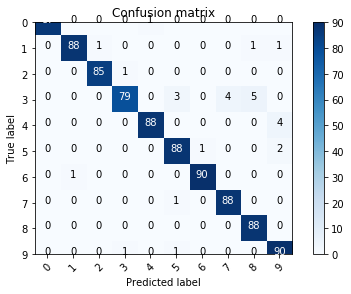

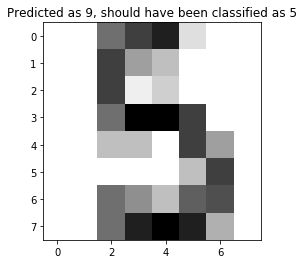

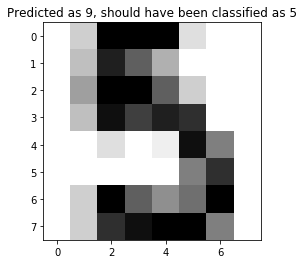

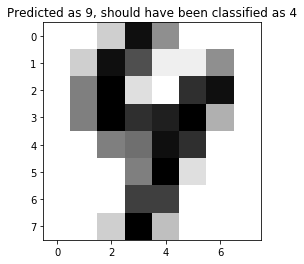

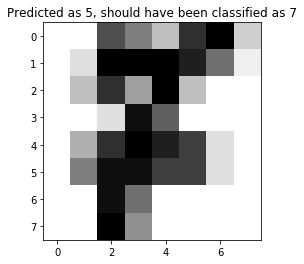

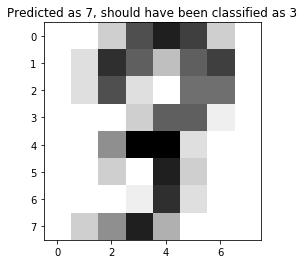

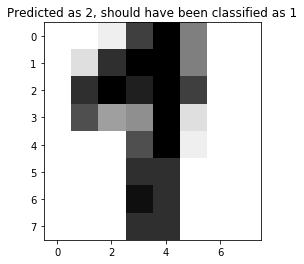

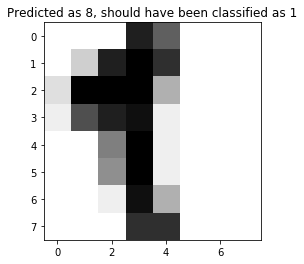

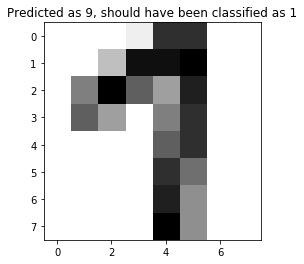

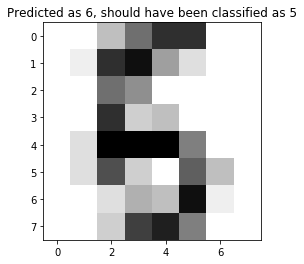

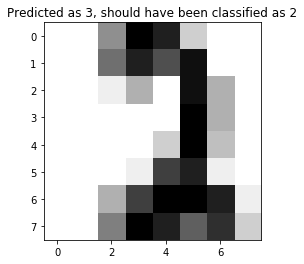

In [207]:
#we predict the classes on the test data
pte = svm.predict(Xte)

# and we calculate the confusion matrix
cm = confusion_matrix(tte, pte)
plot_confusion_matrix(cm, np.unique(tte))

# We show the first 10 misclassification examples:
k=1
for j in range(len(tte)):
    if tte[j]!=pte[j]:
        if k<=10:
            plt.figure()
            plt.imshow(np.reshape(Xte[j,:], (8,8)), cmap=plt.cm.gray_r)
            plt.title("Predicted as %d, should have been classified as %d" % (pte[j],tte[j]))
        k+=1
plt.show()

Again, as shown in the confusion matrix, a lot of the errors in classification are caused by number that look similar, e.g. 3 and 8 or 4 and 9. Some people also draw numbers in different ways that look more similar to other numbers. The digits are also very pixelated, causing uncertainty, as an 8x8 grid is very small. Furthermore, if the digit is not centered properly or is tilted at an angle, it can affect both training and classification.

As with the other models, there are some misclassified examples that could be classified manually, where it is quite obvious what they should be classified as. Hence, we can still make some improvement on this method.

Compare performance of all 3 algorithms for this problem. Discuss the differences in the remaining errors and what would be your suggestion going forward with this dataset. 
<div style="text-align: right"><b>[10 marks]</b></div>

In [213]:
print('Performance on the test set for the k nearest neighbours classifier: %f' % (knn_te))
print('Performance on the test set for the MLP classifier: %f' % (mlp_te))
print('Performance on the test set for the linear SVM classifier: %f' % (Linear_svm_te))
print('Performance on the test set for the non-linear SVM classifier: %f' % (Svm_te))


Performance on the test set for the k nearest neighbours classifier: 0.961068
Performance on the test set for the MLP classifier: 0.932147
Performance on the test set for the linear SVM classifier: 0.944383
Performance on the test set for the non-linear SVM classifier: 0.968854


Although the performance of the classifiers depends heavily on the random seed, a, we tend to see slightly superior performance by the non-linear SVM classifier in comparison with the k nearest neighbours classifier, which in turn is better than both the MLP and linear SVM classifiers.

The MLP, non-linear SVM and k nearest neighbours classifiers misclassify some relatively similar, simple cases, that could be classified by hand. In particular, it is noticeable that the MLP classifier particularly seems to struggle when differentiating between 9's and 1's more than any other classifier. Some of the misclassified digits are tilted at an angle which seems to cause problems for all of the classifiers.

As there are 10 possible classes, it is likely that the 898 training examples is insufficient to train the classifiers. As there will be some classes that have less than 90 training examples.

Hence, if I were to proceed with this dataset, I would increase the proportion of the data used for training (e.g. 1497:300 training data: test data ratio). I would then use this training data to train the k nearest neighbours and non-linear SVM classifiers, as they seem to be the most suitable and highest performance classifiers for this problem.

I would then see if the simple misclassified samples, that could easily be classified by hand, are now able to be classified. If this is the case, then I believe we will have reached the limit with this dataset, as some of the misclassified samples are extremely unclear (and hard to classify- even by hand). 